In [329]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from helpers import *
from implementations import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y_train, X_train, ids = load_csv_data(DATA_TRAIN_PATH)

In [192]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [350]:
X_train_zero, y_train_zero, X_train_one, y_train_one, X_train_many, y_train_many = split_by_jet_num(DATA_TRAIN_PATH, X_train, y_train)
X_test_zero, ids_test_zero, X_test_one, ids_test_one, X_test_many, ids_test_many = split_by_jet_num(DATA_TRAIN_PATH, X_test, ids_test)

In [370]:
def train_predict(X_train, y_train, X_test, max_iters=3000, degree=2, lambda_=0.01, gamma=0.01, imputable_th=0, encodable_th=1, verbose=True):
    tX_train, ty_train, tX_test, _, cont_features = preprocess(X_train, y_train, X_test, imputable_th=imputable_th, encodable_th=encodable_th, switch_encoding=True)
    tX_train_poly = build_poly(tX_train, degree=degree, cont_features=cont_features)
    weights, loss = reg_logistic_regression(ty_train, tX_train_poly, max_iters=max_iters, lambda_=lambda_, gamma=gamma, verbose=verbose)
    tX_test_poly = build_poly(tX_test, degree=degree, cont_features=cont_features)
    y_pred = predict_logistic(weights, tX_test_poly)
    y_pred = replace_values(y_pred, from_val=0, to_val=-1)
    return y_pred, loss

In [371]:
degree = 3
lambda_ = 0.01
gamma = 0.01
max_iters = 3000

In [372]:
y_pred_zero, loss_zero = train_predict(X_train_zero, y_train_zero, X_test_zero, max_iters=max_iters, degree=degree, lambda_=lambda_)

Iteration = 0, accuracy = 27.94130893877674, loss = 6.727596697488854
Iteration = 10, accuracy = 28.79605256573219, loss = 6.081085628702607
Iteration = 20, accuracy = 29.752885009958664, loss = 5.319551166264254
Iteration = 30, accuracy = 31.659543803108704, loss = 4.433847008523932
Iteration = 40, accuracy = 33.99657702200915, loss = 3.7393061653021493
Iteration = 50, accuracy = 36.43569905818062, loss = 3.151343277431871
Iteration = 60, accuracy = 38.881827189655, loss = 2.6623215877031705
Iteration = 70, accuracy = 40.62734579083803, loss = 2.532052651019817
Iteration = 80, accuracy = 43.29366548897541, loss = 2.2129912448807
Iteration = 90, accuracy = 45.78783541681263, loss = 1.953166642564166
Iteration = 100, accuracy = 48.0948425129863, loss = 1.7374785720937314
Iteration = 110, accuracy = 50.322780819312804, loss = 1.5521002394853824
Iteration = 120, accuracy = 52.50567994154915, loss = 1.3912446071902347
Iteration = 130, accuracy = 54.53244322560627, loss = 1.2523997044010233

In [373]:
y_pred_one, loss_one = train_predict(X_train_one, y_train_one, X_test_one, max_iters=max_iters, degree=degree, lambda_=lambda_)

Iteration = 0, accuracy = 42.02130403383885, loss = 6.104387094844045
Iteration = 10, accuracy = 42.68286392241824, loss = 5.594555211764956
Iteration = 20, accuracy = 44.36191065717528, loss = 4.82979683776843
Iteration = 30, accuracy = 46.31048179098318, loss = 4.179661540953334
Iteration = 40, accuracy = 48.25518415351284, loss = 3.630999031230902
Iteration = 50, accuracy = 50.058031569173636, loss = 3.177931151136345
Iteration = 60, accuracy = 51.6416486124007, loss = 2.830689447593989
Iteration = 70, accuracy = 53.09243784174146, loss = 2.54689137603963
Iteration = 80, accuracy = 54.59481068812545, loss = 2.329614451940777
Iteration = 90, accuracy = 55.89213865676261, loss = 2.1551777353278188
Iteration = 100, accuracy = 57.078561848756834, loss = 2.0023296562605672
Iteration = 110, accuracy = 58.1953471577427, loss = 1.8673287947545616
Iteration = 120, accuracy = 59.278603115650476, loss = 1.7477152305039525
Iteration = 130, accuracy = 60.25353347776746, loss = 1.6424493630138752

In [374]:
y_pred_many, loss_many = train_predict(X_train_many, y_train_many, X_test_many, max_iters=max_iters, degree=degree, lambda_=lambda_)

Iteration = 0, accuracy = 47.305735908357796, loss = 6.381916564480615
Iteration = 10, accuracy = 48.2100271563073, loss = 5.814482361010768
Iteration = 20, accuracy = 49.468591042554074, loss = 5.241490305813498
Iteration = 30, accuracy = 51.03318032063741, loss = 4.571145148027995
Iteration = 40, accuracy = 52.94652826599396, loss = 3.809187362868035
Iteration = 50, accuracy = 54.81714293591388, loss = 3.2370884581160833
Iteration = 60, accuracy = 56.22734102532291, loss = 2.8832312249211394
Iteration = 70, accuracy = 57.30256537501896, loss = 2.6264991581090347
Iteration = 80, accuracy = 58.09519870973078, loss = 2.436673103745713
Iteration = 90, accuracy = 58.76101071088872, loss = 2.283523392656949
Iteration = 100, accuracy = 59.46542050921523, loss = 2.1528041954530015
Iteration = 110, accuracy = 60.019574597135495, loss = 2.0377366302023083
Iteration = 120, accuracy = 60.60405552568822, loss = 1.9347649073388526
Iteration = 130, accuracy = 61.06860758446714, loss = 1.84177541019

In [363]:
y_pred = np.vstack([y_pred_zero, y_pred_one, y_pred_many])
ids_test = np.hstack([ids_test_zero, ids_test_one, ids_test_many])

In [ ]:
from datetime import datetime
method = 'reg_logistic_regression_by_jet'
time = datetime.now().strftime('%Y%m%dH%H%M%S')
OUTPUT_PATH = f'../submissions/submission_{method}_{time}'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [268]:
param_grid = {
    'lambda_': np.logspace(-4, 0, 5),
    'degree': list(range(1, 4)),
    'max_iters': 100,
    'gamma': [0.01, 0.05, 0.1],
    'cont_features': [cont_features]
}
metrics, params = logistic_regression_cv(ty_train, tX_train, param_grid=param_grid)

Iteration = 0, accuracy = 54.170159262363796, loss = 1.5323666800943292
Iteration = 10, accuracy = 55.99651815075117, loss = 1.2643337161891277
Iteration = 20, accuracy = 57.940550648010834, loss = 1.0406710994267085
Iteration = 30, accuracy = 60.049003804242695, loss = 0.8703659187003343
Iteration = 40, accuracy = 62.14133728802631, loss = 0.7546645024013069
Iteration = 50, accuracy = 64.00960732477915, loss = 0.6837798912659867
Iteration = 60, accuracy = 65.4361983364498, loss = 0.6421292619204373
Iteration = 70, accuracy = 66.6209942613966, loss = 0.6167229695321716
Iteration = 80, accuracy = 67.48662067186795, loss = 0.600106852692552
Iteration = 90, accuracy = 68.05403314204655, loss = 0.5885332703344683
Iteration = 0, accuracy = 55.001934360693795, loss = 1.5500540440506312
Iteration = 10, accuracy = 56.88793603713973, loss = 1.2871752656333064
Iteration = 20, accuracy = 58.94803017602682, loss = 1.0629032404526433
Iteration = 30, accuracy = 61.253143336127415, loss = 0.885669325

In [126]:
ty_train_pred = predict_logistic(weights, tX_train_poly)
train_accuracy = compute_accuracy(ty_train, ty_train_pred)
train_f1 = compute_f1(ty_train, ty_train_pred)
train_accuracy, train_f1

(79.75244444444445, 0.6849947795302268)

In [127]:
tX_val_poly = build_poly(tX_test, degree=params['degree'], cont_features=cont_features)
ty_val_pred = predict_logistic(weights, tX_val_poly)
val_accuracy = compute_accuracy(ty_test, ty_val_pred)
val_f1 = compute_f1(ty_test, ty_val_pred)
val_accuracy, val_f1

(78.412, 0.6540162830950702)

In [129]:
val_tmp = np.hstack([X_train_val, ty_val_pred, ty_test])

In [142]:
val_tmp_mis = val_tmp[val_tmp[:, -1] != val_tmp[:, -2]]

In [143]:
tval_tmp = replace_values(val_tmp_mis, -999, np.nan)
col_nan_ratio = compute_nan_ratio(tval_tmp)

In [144]:
col_nan_ratio

array([0.05984806, 0.        , 0.        , 0.        , 0.67129887,
       0.67129887, 0.67129887, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.67129887, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.32666296, 0.32666296,
       0.32666296, 0.67129887, 0.67129887, 0.67129887, 0.        ,
       0.        , 0.        ])

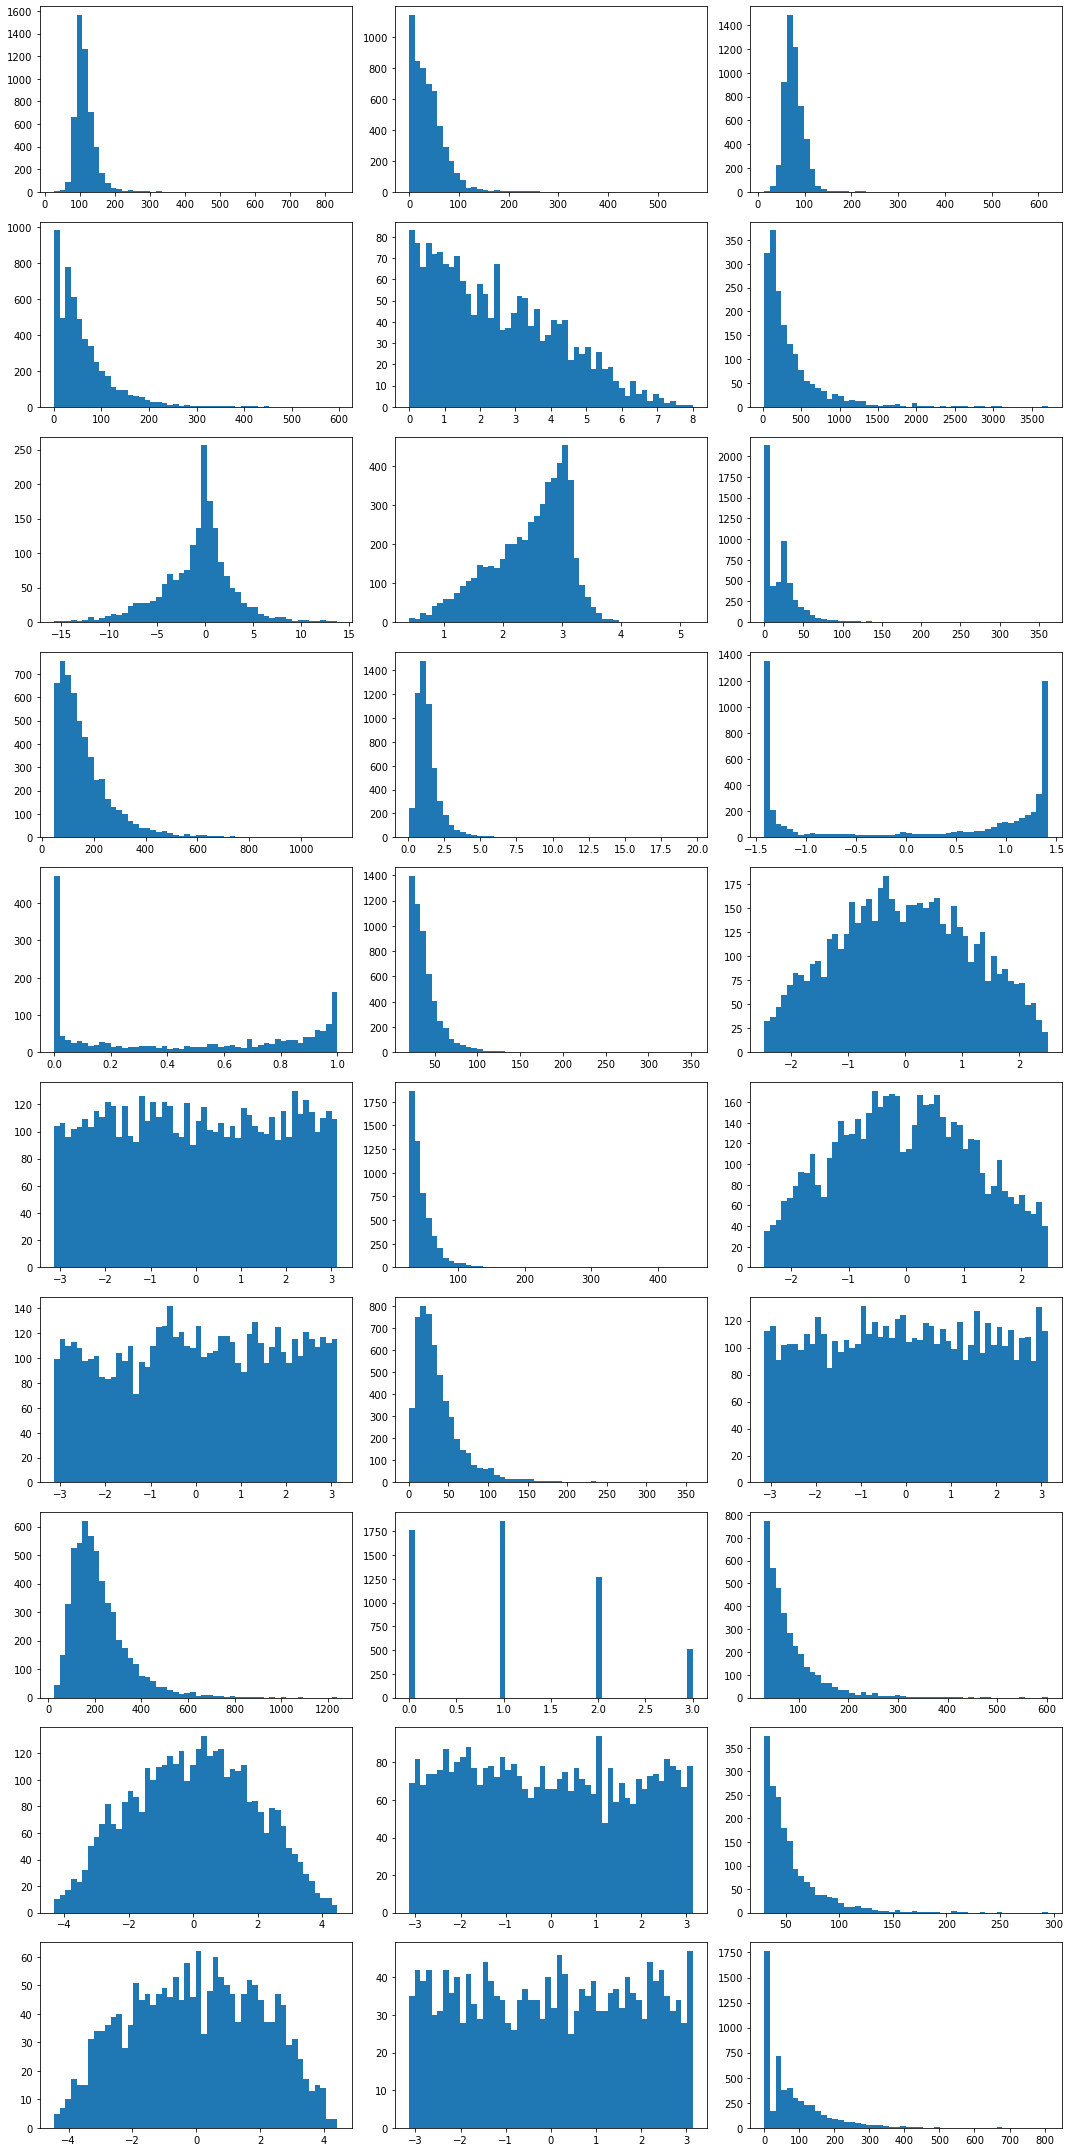

In [145]:
def plot_features_distrib(tX):
    plt.figure(figsize=(15,30))
    for i in range(tX.shape[1]):
        plt.subplot(10,3,i+1)
        plt.hist(tX[:,i], bins=50);
        # plt.title("Feature {}: {}".format(i, labels[i]))
    plt.tight_layout()
    plt.show();
plot_features_distrib(tval_tmp[:, :-2])

In [50]:
tX_test.shape

(568238, 24)

In [51]:
tX_test_poly = build_poly(tX_test, params['degree'], cont_features)

In [52]:
tX_test_poly.shape

(568238, 44)

In [365]:
from datetime import datetime
method = 'reg_logistic_regression_by_jet'
time = datetime.now().strftime('%Y%m%dH%H%M%S')
OUTPUT_PATH = f'../submissions/submission_{method}_{time}'
# y_pred = predict_logistic(weights, tX_test_poly)
# y_pred = replace_values(y_pred, from_val=0, to_val=-1)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)